In [1]:
import warnings
from string import ascii_lowercase
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from datetime import date, datetime

import mapclassify
import geopandas as gpd
from shapely.geometry import Polygon as ShapPolygon
from shapely.ops import unary_union
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from matplotlib.colors import to_rgb
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon as MpPolygon, Path, PathPatch
import matplotlib.patheffects as pe

from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
# Importa dati vaccini e dati epidemiologici - https://github.com/apalladi/covid_vaccini_monitoraggio/blob/main/scripts/confronti_europei.py
def import_vaccines_data():
    """ Recupera dati sui vaccini da Our World in Data"""
    url = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv"  
    df_vacc = pd.read_csv(url)
    df_vacc = df_vacc.fillna(method="ffill")
    return df_vacc

def get_vaccine_data(country):
    """ Recupera dati vaccini per paese """

    df_vacc_country = df_vacc[df_vacc["location"] == country].iloc[2:, :]

    date = pd.to_datetime(df_vacc_country["date"])
    vacc1 = np.array(df_vacc_country["people_vaccinated_per_hundred"])
    vacc2 = np.array(df_vacc_country["people_fully_vaccinated_per_hundred"])

    df_vacc_new = pd.DataFrame(np.transpose([vacc1, vacc2]))
    df_vacc_new.index = date
    df_vacc_new.columns = ["% vaccinated with 1 dose", "% fully vaccinated"]

    return df_vacc_new

def import_epidem_data():
    """ Recupera dati epidemiologici dal JHU CSSE
        (Johns Hopkins Unversity)"""

    base = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"  # noqa: E501
    file_confirmed = base + "time_series_covid19_confirmed_global.csv"
    file_deaths = base + "time_series_covid19_deaths_global.csv"
    file_recovered = base + "time_series_covid19_recovered_global.csv"
    return pd.read_csv(file_confirmed), pd.read_csv(file_deaths), pd.read_csv(file_recovered)

def get_vaccine_data_last(country, days_ago=30, fully=False):
    """ Recupera dati sulla frazione di vaccinati """
    frac_vacc = get_vaccine_data(country)["% fully vaccinated"
                                          if fully else
                                          "% vaccinated with 1 dose"]
    return frac_vacc.iloc[-days_ago]


def get_deaths(country, time_window=30, t0=-1):
    """ Recupera decessi per la finestra temporale selezionata """
    decessi = np.array(df_deaths[df_deaths["Country/Region"] == country].iloc[:, 4:].sum())
    decessi_ultimi_Ngiorni = decessi[t0] - decessi[t0-(time_window+1)]
    return decessi_ultimi_Ngiorni


def compute_vaccini_decessi_eu(time, fully=True):
    """ calcola vaccini e decessi nei 27 Paesi europei """

    dec_res_2021 = []
    vacc_res_2021 = []
    t0 = -1
    for p, abitanti in paesi_abitanti_eu.items():
        vacc_res_2021.append(get_vaccine_data_last(p,
                                                   days_ago=time,
                                                   fully=fully))
        dec_res_2021.append(get_deaths(p, time_window=time, t0=t0)/abitanti)
    dec_res_2021 = np.array(dec_res_2021)
    return vacc_res_2021, dec_res_2021

def linear_model(x, coeff_fit):
    y = coeff_fit[1] + coeff_fit[0]*x
    return y

def linear_fit(vacc_res_2021, dec_res_2021):
    """ fit lineare """

    coeff_fit = np.polyfit(vacc_res_2021, dec_res_2021, 1)
    x_grid = np.arange(0, 100, 1)
    y_grid = [linear_model(v, coeff_fit) for v in x_grid]

    # calcola R2 score
    y_pred = [linear_model(v, coeff_fit) for v in vacc_res_2021]
    y_test = dec_res_2021

    score = round(r2_score(y_test, y_pred), 2)
    print('R2 score è pari a', score)

    return x_grid, y_grid, score

In [3]:
def get_map_labels(countries_df, extent_polygon, basemap_map):
    """ Get map labels """
    map_labels = []
    countries_df_clip = gpd.clip(countries_df, extent_polygon)
    for _, row in countries_df_clip.iterrows():
        if row["ADM0_A3_IT"] in adm0_a3_it.values(): 
            label_ctx = row["geometry"].representative_point()
            label_ctx = basemap_map(label_ctx.x, label_ctx.y)
            labelx, labely = label_ctx[0], label_ctx[1]
            if row["ADM0_A3_IT"] == "LUX":
                labelx, labely = labelx + 120000, labely
            if row["ADM0_A3_IT"] == "CYP":
                labelx, labely = labelx, labely - 125000
            if row["ADM0_A3_IT"] == "MLT":
                labelx, labely = labelx, labely - 60000
            map_labels.append((row["ADM0_A3_IT"], (labelx, labely)))
    return map_labels

In [4]:
def get_eu_patches(eu_countries, basemap_map):
    """ Get EU-27 patches"""
    eu_patches = []
    eu_colors = []
    for _, row in eu_countries.iterrows():
        geom = row["geometry"]
        if geom.geom_type == "MultiPolygon":
            for part in geom:
                coords = np.array([basemap_map(cd[0], cd[1]) for cd in part.exterior.coords[:]])
                eu_patches.append(MpPolygon(coords, True))
                eu_colors.append(row["Biv_color"])
        else:
            coords = np.array([basemap_map(cd[0], cd[1]) for cd in geom.exterior.coords[:]])
            eu_patches.append(MpPolygon(coords, True))
            eu_colors.append(row["Biv_color"])
    return eu_patches, eu_colors

In [5]:
def get_wld_patches(countries_df, basemap_map):
    """ Get world patches"""
    wld_patches = []
    for _, row in countries_df.iterrows():
        if row["ADM0_A3_IT"] not in eu_countries["ADM0_A3_IT"]:
            geom = row["geometry"]
            if geom.geom_type == "MultiPolygon":
                for part in geom:
                    coords = np.array([basemap_map(c[0], c[1]) for c in part.exterior.coords[:]])
                    wld_patches.append(MpPolygon(coords, True))
            else:
                coords = np.array([basemap_map(c[0], c[1]) for c in geom.exterior.coords[:]])
                wld_patches.append(MpPolygon(coords, True))
    return wld_patches

In [6]:
# Source: https://sgillies.net/2010/04/06/painting-punctured-polygons-with-matplotlib.html
def ring_coding(ob):
    # The codes will be all "LINETO" commands, except for "MOVETO"s at the
    # beginning of each subpath
    n = len(ob.coords)
    codes = np.ones(n, dtype=Path.code_type) * Path.LINETO
    codes[0] = Path.MOVETO
    return codes

def pathify(polygon):
    # Convert coordinates to path vertices. Objects produced by Shapely's
    # analytic methods have the proper coordinate order, no need to sort.
    vertices = np.concatenate(
                    [np.asarray(polygon.exterior)]
                    + [np.asarray(r) for r in polygon.interiors])
    codes = np.concatenate(
                [ring_coding(polygon.exterior)]
                + [ring_coding(r) for r in polygon.interiors])
    return Path(vertices, codes)

In [7]:
# Sequential bivariate color schemes - https://www.joshuastevens.net/cartography/make-a-bivariate-choropleth-map/
map_colors_1 = {"A2": "#6c83b5", "B2": "#567994", "C2": "#2a5a5b",
            "A1": "#b5c0da", "B1": "#90b2b3", "C1": "#5a9178",
            "A0": "#e8e8e8", "B0": "#b8d6be", "C0": "#73ae80"}

map_colors_2 = {"A2": "#c85a5a", "B2": "#985356", "C2": "#574249",
            "A1": "#e4acac", "B1": "#ad9ea5", "C1": "#627f8c",
            "A0": "#e8e8e8", "B0": "#b0d5df", "C0": "#64acbe"}

map_colors_3 = {"A2": "#be64ac", "B2": "#8c62aa", "C2": "#3b4994",
            "A1": "#dfb0d6", "B1": "#a5add3", "C1": "#5698b9",
            "A0": "#e8e8e8", "B0": "#ace4e4", "C0": "#5ac8c8"}

map_colors_4 = {"A2": "#c8b35a", "B2": "#af8e53", "C2": "#804d36",
            "A1": "#e4d9ac", "B1": "#c8ada0", "C1": "#976b82",
            "A0": "#e8e8e8", "B0": "#cbb8d7", "C0": "#9972af"}

output_map_colors = map_colors_1
bivariate_letters = {index: letter.upper() for index, letter in enumerate(ascii_lowercase, start=0)}
bivariate_legend = np.array([to_rgb(rgb) for rgb in list(output_map_colors.values())]).reshape(3, 3, 3)

texts_fontsize = 12
admin_fontsize = 12
title_fontsize = 14
black_color = "#1a2421"
grey_color ="#DDDDDD"
ocean_color = '#EBF4FA'

In [8]:
# Europe extent
lon_min, lat_min, lon_max, lat_max = -15.5, 33, 40, 71

# Extent polygon
extent_polygon = ShapPolygon([(lon_min, lat_min), 
                              (lon_max, lat_min), 
                              (lon_max, lat_max), 
                              (lon_min, lat_max), 
                              (lon_min, lat_min)])

In [9]:
# Map Classifier
map_classifier = mapclassify.JenksCaspall.make(k=3)

In [10]:
paesi_abitanti_eu = {"Austria": 8.917, "Belgium": 11.56, "Bulgaria": 6.927,
                     "Cyprus": 1.207, "Croatia": 4.047, "Denmark": 5.831,
                     "Estonia": 1.331, "Finland": 5.531, "France": 67.39,
                     "Germany": 83.24, "Greece": 10.27, "Ireland": 4.995,
                     "Italy": 59.55, "Latvia": 1.902, "Lithuania": 2.795,
                     "Luxembourg": 0.632275, "Malta": 0.525285, "Netherlands": 17.44,
                     "Poland": 37.95, "Portugal": 10.31, "Czechia": 10.7,
                     "Romania": 19.29, "Slovakia": 5.549, "Slovenia": 2.1,
                     "Spain": 47.35, "Sweden": 10.35, "Hungary": 9.75}

adm0_a3_it = {"Austria":"AUT", "Belgium":"BEL", "Bulgaria":"BGR", "Cyprus":"CYP", 
              "Croatia":"HRV", "Denmark":"DNK", "Estonia":"EST", "Finland":"FIN", 
              "France":"FRA", "Germany":"DEU", "Greece":"GRC", "Ireland":"IRL", 
              "Italy":"ITA", "Latvia":"LVA", "Lithuania":"LTU", "Luxembourg":"LUX", 
              "Malta":"MLT", "Netherlands":"NLD", "Poland":"POL", "Portugal":"PRT", 
              "Czechia":"CZE", "Romania":"ROU", "Slovakia":"SVK", "Slovenia":"SVN", 
              "Spain":"ESP", "Sweden":"SWE", "Hungary":"HUN"}

In [11]:
window = abs((date.today() - date(2021, 9, 22)).days)  # da inizio autunno (22 settembre 2021)

# importa dati
df_confirmed, df_deaths, df_recovered = import_epidem_data()
df_vacc = import_vaccines_data()

# recupera dati per tale finestra temporale
vacc_res_2021, dec_res_2021 = compute_vaccini_decessi_eu(window, fully=False)

# Fit lineare
x_grid, y_grid, score = linear_fit(vacc_res_2021, dec_res_2021)

# calcola coefficiente di correlazione (pearson)
corr_coeff = round(np.corrcoef(vacc_res_2021, dec_res_2021)[0, 1], 2)

R2 score è pari a 0.49


In [12]:
# Create a dataframe with Vaccinated and deaths
vacc_dec_2021 = pd.DataFrame(zip(paesi_abitanti_eu.keys(), vacc_res_2021, dec_res_2021), 
                             columns = ["Country", "Vax", "Dth"])

# Add country abbreviation column
vacc_dec_2021["ADM0_A3_IT"] = vacc_dec_2021.apply(lambda row: adm0_a3_it[row['Country']], axis=1)

In [13]:
# Open 50m World Countries from natural earth
countries_df = gpd.read_file("../Data/ne_50m_admin_0_countries.shp")

# Get borders recognized by Italy
countries_df = countries_df.dissolve(by='ADM0_A3_IT', aggfunc='last').reset_index()

# Get European countries
eu_countries = pd.merge(countries_df, vacc_dec_2021, left_on='ADM0_A3_IT', 
                        right_on='ADM0_A3_IT')[["ADM0_A3_IT", "Country", "Vax", "Dth", "geometry"]]

In [14]:
# Create the bivariate classes
eu_countries["Dth_class"] = eu_countries[['Dth']].apply(map_classifier).astype(str)
eu_countries["Vax_class"] = eu_countries[['Vax']].apply(map_classifier)
eu_countries["Vax_class_lett"] = eu_countries.apply(lambda row: bivariate_letters[row['Vax_class']], axis=1)
eu_countries["Biv_class"] = eu_countries["Vax_class_lett"].str.cat(eu_countries["Dth_class"])
eu_countries["Biv_color"] = eu_countries.apply(lambda row: output_map_colors[row['Biv_class']], axis=1)

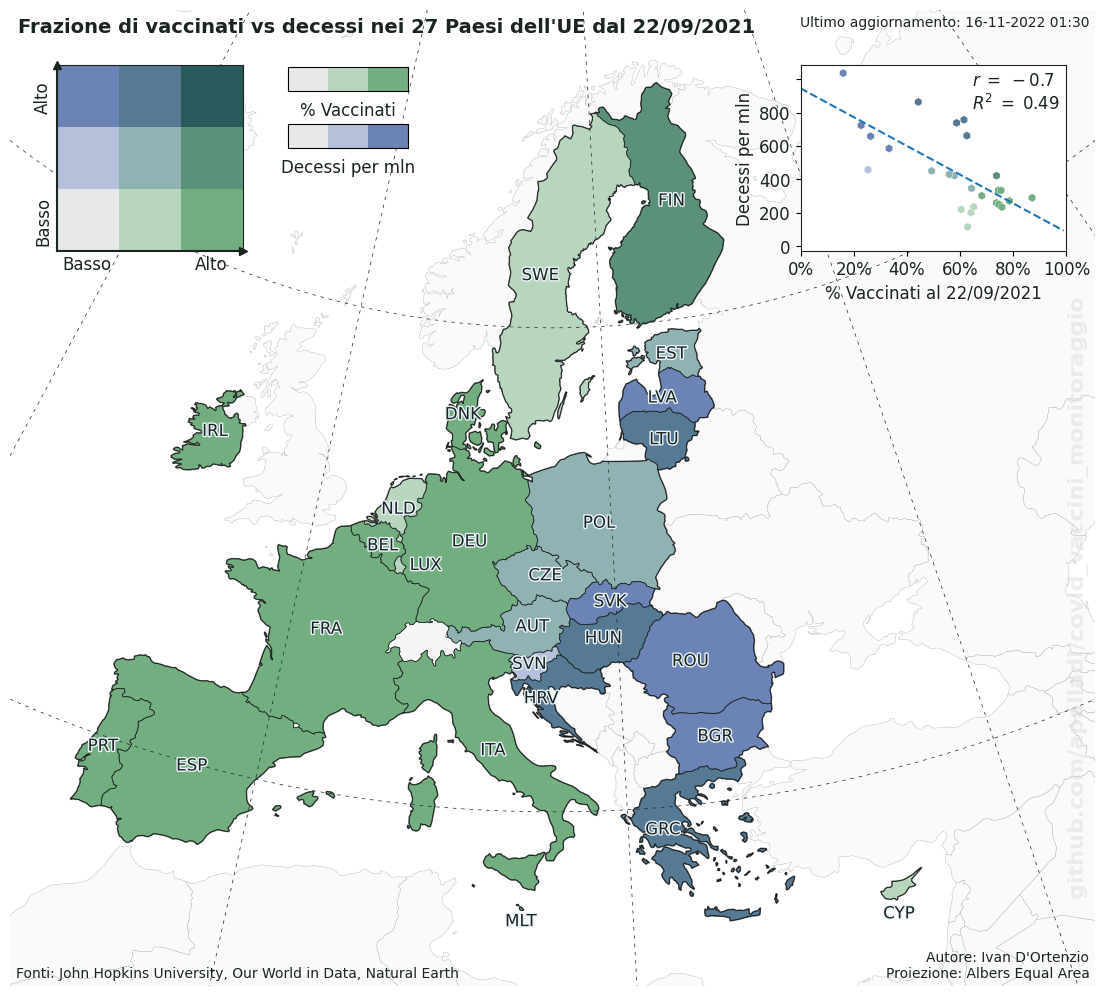

In [15]:
fig = plt.figure(figsize=(14, 14))
ax = plt.subplot(111)

# Remove white margins
ax.set_axis_off()
ax.margins(0)

# Create a map, set projection to aea
basemap_map = Basemap(resolution='l', projection='aea', width=5000000, height=4500000, 
                      lat_1=45, lat_2=60, lon_0=16, lat_0=53)

# Draw parallels and meridians
dashes = [5,7]
basemap_map.drawparallels(np.arange(-80.,81.,20.), 
                          dashes=dashes, 
                          linewidth=0.5,
                          color=black_color)
basemap_map.drawmeridians(np.arange(-180.,181.,20.),
                          dashes=dashes, 
                          linewidth=0.5, 
                          color=black_color)

# Map boundary
xx_min, xx_max = ax.get_xbound()
yy_min, yy_max = ax.get_ybound()
map_extent_polygon = ShapPolygon([(xx_min, yy_min), 
                                  (xx_max, yy_min), 
                                  (xx_max, yy_max), 
                                  (xx_min, yy_max), 
                                  (xx_min, yy_min)])

# Get EU-Countries patches
eu_patches, eu_colors = get_eu_patches(eu_countries, basemap_map)

# Get World-Countries patches
wld_patches = get_wld_patches(countries_df, basemap_map)

# Get map labels
map_labels = get_map_labels(countries_df, extent_polygon, basemap_map)

# Add World countries
ax.add_collection(PatchCollection(wld_patches, 
                                  facecolor="whitesmoke", 
                                  edgecolor=black_color, 
                                  linewidths=0.25))

# Add Bivariate map
ax.add_collection(PatchCollection(eu_patches, 
                                  facecolor=eu_colors, 
                                  edgecolor=black_color, 
                                  linewidths=0.6))

# Fade effect
eu_patches_union = unary_union([ShapPolygon(eu_patch.xy) 
                                for eu_patch in eu_patches])

fade_path = pathify(map_extent_polygon.buffer(100000).difference(eu_patches_union)[0])
fade_patch = PathPatch(fade_path, facecolor='white', alpha=0.6)
ax.add_patch(fade_patch)

# Add EU-countries labels
for label in map_labels:
    ax.annotate(label[0], (label[1][0], label[1][1]), 
                color=black_color,
                fontsize=admin_fontsize,
                ha="center", 
                va="center", 
                path_effects=[pe.withStroke(linewidth=2, 
                                            foreground=ocean_color)])

# Add map title
title = "Frazione di vaccinati vs decessi nei 27 Paesi dell'UE dal 22/09/2021"
map_title = AnchoredText(title,
                         prop=dict(color=black_color,
                                   fontsize=title_fontsize,
                                   weight="bold",
                                   ha="center"),
                         borderpad=0, 
                         frameon=False, 
                         loc=2)
ax.add_artist(map_title)

# Add map credits
map_sources = AnchoredText("Fonti: John Hopkins University, Our World in Data, Natural Earth", 
                       prop=dict(color=black_color, 
                                 fontsize=texts_fontsize-2), 
                       borderpad=0., 
                       frameon=False, 
                       loc=3)
ax.add_artist(map_sources)

# Add map author
map_author = AnchoredText("Autore: Ivan D'Ortenzio\nProiezione: Albers Equal Area", 
                      prop=dict(color=black_color, 
                                fontsize=texts_fontsize-2, 
                                ha="right"), 
                      borderpad=0., 
                      frameon=False, 
                      loc=4)
ax.add_artist(map_author)

# Add watermark
fig.text(0.88, 0.425,
        'github.com/apalladi/covid_vaccini_monitoraggio', 
         fontsize=16, 
         weight="bold", 
         color=grey_color,
         alpha=0.5,
         va="center", 
         rotation='vertical')
    
# Add last update date
last_update = datetime.today().strftime("%d-%m-%Y %H:%M")
map_date = AnchoredText(f"Ultimo aggiornamento: {last_update}", 
                        prop=dict(color=black_color, 
                                  fontsize=texts_fontsize-2), 
                        borderpad=0., 
                        frameon=False, 
                        loc=1)
ax.add_artist(map_date)

# Add bivariate map legend
map_legend = inset_axes(ax, "25%", "20%", 
                        loc="upper left", 
                        bbox_to_anchor=(0, 0., 0.98, 0.95), 
                        bbox_transform=ax.transAxes)
map_legend.imshow(bivariate_legend, extent=(0, 1, 0, 1))
map_legend.set_xticks([0.16, 0.5, 0.83])
map_legend.set_yticks([0.16, 0.5, 0.83])
map_legend.tick_params(axis=u'both', which=u'both', length=0)
map_legend.set_xticklabels(["Basso", "", "Alto"], 
                color=black_color,
                fontsize=texts_fontsize)
map_legend.set_yticklabels(["Basso", "", "Alto"], 
                color=black_color,
                rotation=90,
                va="center",
                fontsize=texts_fontsize)
map_legend.plot(1, 0, ">", color=black_color,
                transform=map_legend.get_yaxis_transform(), 
                clip_on=False)
map_legend.plot(0, 1, "^", color=black_color,
                transform=map_legend.get_xaxis_transform(), 
                clip_on=False)
map_legend.spines['left'].set_linewidth(1.5)
map_legend.spines['left'].set_color(black_color)
map_legend.spines['bottom'].set_linewidth(1.5)
map_legend.spines['bottom'].set_color(black_color)
map_legend.spines['top'].set_color(black_color)
map_legend.spines['right'].set_color(black_color)
map_legend.set_facecolor((0, 0, 0, 0))

# Add Vax legend
vax_array = bivariate_legend[2:, :, :]
vax_legend = inset_axes(ax, "10%", "5%", 
                        loc="upper left", 
                        bbox_to_anchor=(0.25, 0, 1.10, 0.96), 
                        bbox_transform=ax.transAxes)
vax_legend.imshow(vax_array, extent=(0, 1, 0, 0.2))
vax_legend.set_xlabel("% Vaccinati", 
                      color=black_color,
                      fontsize=texts_fontsize)
vax_legend.set_xticks([])
vax_legend.set_yticks([])
vax_legend.set_xticklabels([])
vax_legend.set_yticklabels([])

# Add Dth legend
dth_array = np.fliplr(bivariate_legend[:, :1, :].reshape(1, 3, 3))
dth_legend = inset_axes(ax, "10%", "5%", 
                        loc="upper left", 
                        bbox_to_anchor=(0.25, 0, 1.10, 0.90), 
                        bbox_transform=ax.transAxes)

dth_legend.imshow(dth_array, extent=(0, 1, 0, 0.2))
dth_legend.set_xlabel("Decessi per mln", 
                      color=black_color, 
                      fontsize=texts_fontsize)
dth_legend.set_xticks([])
dth_legend.set_yticks([])
dth_legend.set_xticklabels([])
dth_legend.set_yticklabels([])

# Add the scatter plot
ax_scatter = inset_axes(ax, "25%", "20%", 
                        loc="upper right", 
                        bbox_to_anchor=(0, 0., 0.98, 0.95), 
                        bbox_transform=ax.transAxes)

ax_scatter.scatter(eu_countries["Vax"], 
                   eu_countries["Dth"], 
                   color=eu_countries["Biv_color"], 
                   marker="h", 
                   edgecolor="white",
                   linewidth=0.25)

ax_scatter.plot(x_grid, y_grid, linestyle="--")

ax_scatter.set_ylabel(r'Decessi per mln',
                      color=black_color,
                      fontsize=texts_fontsize)
ax_scatter.set_xlabel(r'% Vaccinati al 22/09/2021',
                      color=black_color,
                      fontsize=texts_fontsize)
ax_scatter.set_yticklabels(["-70", "0", "200", "400", "600", "800"], 
                           color=black_color, 
                           fontsize=texts_fontsize)
ax_scatter.set_xticklabels(["0%", "20%", "40%", "60%", "80%", "100%"], 
                           color=black_color, 
                           fontsize=texts_fontsize)
ax_scatter.spines['top'].set_color(black_color)
ax_scatter.spines['bottom'].set_color(black_color)
ax_scatter.spines['left'].set_color(black_color)
ax_scatter.spines['right'].set_color(black_color)
ax_scatter.set_ylim(-70, )
ax_scatter.set_xlim(0, 100)

# Annotate r and R^2
ax_scatter_legend = AnchoredText(f"$r\;=\;{corr_coeff}$\n$R^2\;=\;{score}$", 
                                 prop=dict(color=black_color, 
                                           fontsize=texts_fontsize, 
                                           ha="left"), 
                                 borderpad=0, 
                                 frameon=False, 
                                 loc=1)
ax_scatter.add_artist(ax_scatter_legend)

# Save the map
plt.savefig("01_Vax_vs_Deaths_Biv_Map.jpg",
            dpi=300,
            bbox_inches='tight',
            pad_inches=0, 
            facecolor=ocean_color)
#plt.close()